In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from tqdm import tqdm

# **Data Preparation**

---



In [ ]:
df_Cbg = pd.read_csv('./drive/MyDrive/Material Informatics/Conductive polymer QSAR/Table of Supporting Information(SMILES)- Cal band gap.csv')
df_Cbg['Mols'] = df_Cbg['SMILES'].apply(lambda x : Chem.MolFromSmiles(x))

In [ ]:
df_Cbg.tail()

In [ ]:
df_Cbg.isna().any()

NO.                False
Repeating units    False
DFT band gap/eV    False
SMILES             False
Mols               False
dtype: bool

In [ ]:
class Morgan_fingerprint():
    
    def __init__(self,mols):
        self.mols = mols
        self.bitExamples = {}
        self.keepMols = {}
        return
    
    def calculate(self,radius=2,bits=1024,vector_type="count",unhash=False):
        if vector_type not in ["count","bit"]: 
            return
        elif vector_type=="bit":
            unhash=False
            fp_all = defaultdict()
            
        mols = self.mols
        self.bits = bits
        self.radius = radius
        self.bitI_morgan =  {}
        morgan_count = defaultdict(lambda:[0]*len(mols))
        for idx,mol in enumerate(tqdm(mols)):
            self.bitI_morgan[idx] = {}
            if unhash==True:
                fp_morgan = AllChem.GetMorganFingerprint(mol, radius, bitInfo=self.bitI_morgan[idx])
            else:
                fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, 
                                                                  bitInfo=self.bitI_morgan[idx],nBits=bits)
                if vector_type=="bit":
                    arr = np.zeros((1,))
                    DataStructs.ConvertToNumpyArray(fp_morgan, arr)
                    fp_all[idx]= arr
            for key in list(self.bitI_morgan[idx].keys()):
                morgan_count["{}".format(key)][idx]=len(self.bitI_morgan[idx][key])
                #generate bit examples for visualization
                self.bitExamples[key] = idx
                self.keepMols[idx]=mol
                
        if vector_type=="bit": return pd.DataFrame.from_dict(fp_all).T #Bit type       
        return pd.DataFrame.from_dict(morgan_count)

In [ ]:
mf_Cbg = Morgan_fingerprint(df_Cbg["Mols"].values)
fp_Cbg = mf_Cbg.calculate(radius=2,bits=1024,vector_type="count",unhash=False)
print (fp_Cbg.columns)

100%|██████████| 284/284 [00:00<00:00, 6439.52it/s]

Index(['41', '80', '95', '97', '110', '128', '226', '247', '264', '302',
       ...
       '452', '293', '844', '955', '227', '496', '111', '148', '208', '662'],
      dtype='object', length=435)


In [ ]:
fp_Cbg.to_csv("hashed MF_Cal band gap.csv")

In [ ]:
fp_Cbg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Columns: 435 entries, 41 to 662
dtypes: int64(435)
memory usage: 965.3 KB


In [ ]:
# A list for the evaluation result
r2_sum = pd.DataFrame()
rmse_sum = pd.DataFrame()

# **Hold-out Validation**

---



In [ ]:
X = fp_Cbg
y = df_Cbg.iloc[:, -3]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## ***Linear Regression Model***

### ***Linear Regression(Ordinary)***

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, lr.predict(X_test))
RMSE = mean_squared_error(y_test, lr.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, lr.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, lr.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: -7.464661631199408e+23
RMSE: 990736557650.3613
MSE:　9.815589266648878e+23
MAE:　518517704290.3437


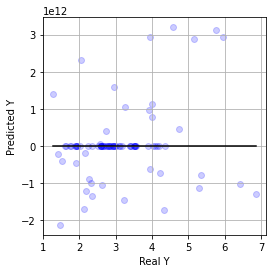

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, lr.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'Linear Regression(Ordinary)'] = R_square
rmse_sum.loc['Hold-out Validation', 'Linear Regression(Ordinary)'] = RMSE

### ***Linear Regression(Lasso)*** 

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, lasso.predict(X_test))
RMSE = mean_squared_error(y_test, lasso.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, lasso.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, lasso.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.6761396486419031
RMSE: 0.6525773812440006
MSE:　0.42585723851127766
MAE:　0.49209131481998863


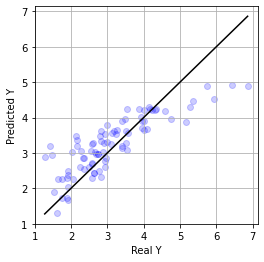

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'Linear Regression(Lasso)'] = R_square
rmse_sum.loc['Hold-out Validation', 'Linear Regression(Lasso)'] = RMSE

### ***Linear Regression(Ridge)*** 

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, ridge.predict(X_test))
RMSE = mean_squared_error(y_test, ridge.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, ridge.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, ridge.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.8545029208658825
RMSE: 0.4374014947981216
MSE:　0.1913200676516312
MAE:　0.3157577479365919


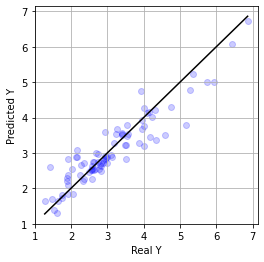

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'Linear Regression(Ridge)'] = R_square
rmse_sum.loc['Hold-out Validation', 'Linear Regression(Ridge)'] = RMSE

### ***Linear Regression(ElasticNet)*** 

In [ ]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, EN.predict(X_test))
RMSE = mean_squared_error(y_test, EN.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, EN.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, EN.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.6968651055576289
RMSE: 0.6313513177921363
MSE:　0.39860448647786706
MAE:　0.46769883393267225


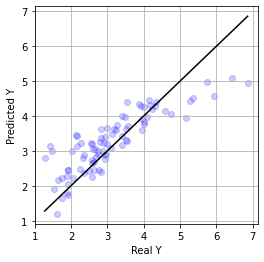

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'Linear Regression(ElasticNet)'] = R_square
rmse_sum.loc['Hold-out Validation', 'Linear Regression(ElasticNet)'] = RMSE

## ***Random Forest Model***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, rf.predict(X_test))
RMSE = mean_squared_error(y_test, rf.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, rf.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, rf.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.9086735409527809
RMSE: 0.3465384552119687
MSE:　0.12008890094069763
MAE:　0.26193081395348816


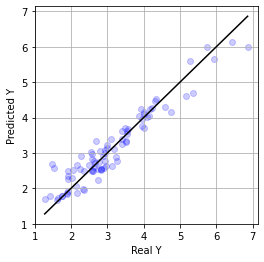

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'RF'] = R_square
rmse_sum.loc['Hold-out Validation', 'RF'] = RMSE

## ***SVR Model***

In [ ]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)

SVR()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, svr.predict(X_test))
RMSE = mean_squared_error(y_test, svr.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, svr.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, svr.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.7010317119881933
RMSE: 0.6269973245989683
MSE:　0.39312564505426395
MAE:　0.419941663897945


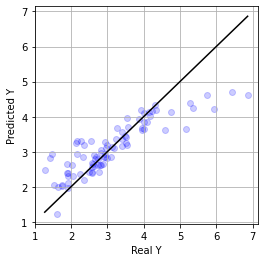

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'SVR'] = R_square
rmse_sum.loc['Hold-out Validation', 'SVR'] = RMSE

### **SVR Model(GridSearchCV)**

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 10]} #The list in each parameters can be tuple or square brackets.

svr = SVR()
grid_svr = GridSearchCV(svr, parameters)
grid_svr.fit(X_train, y_train)

print(grid_svr.best_params_)
print(grid_svr.best_score_)

{'C': 10, 'kernel': 'rbf'}
0.8319086410323167


In [ ]:
pred = grid_svr.best_estimator_.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, pred)
RMSE = mean_squared_error(y_test, pred, squared=False)
MSE = mean_squared_error(y_test, pred, squared=True)
MAE = mean_absolute_error(y_test, pred)

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.8782996607101108
RMSE: 0.4000359482876846
MSE:　0.16002875992242704
MAE:　0.2962153638655656


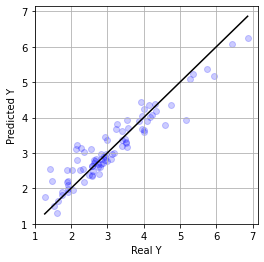

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, pred, alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'SVR(GridSearchCV)'] = R_square
rmse_sum.loc['Hold-out Validation', 'SVR(GridSearchCV)'] = RMSE

## ***XGBoost Model***

In [ ]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
params = {'metric':'rmse',
          'objective':'reg:squarederror',
          'n_estimators':5000,
          'booster': 'gbtree',
          'learning_rate':0.01,
          'min_child_weight':1,
          'max_depth':5,
          'random_state':0,
          'colsample_bytree':1,
          'subsample':1,
         }
xgb_reg.set_params(**params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(learning_rate=0.01, max_depth=5, metric='rmse', n_estimators=5000,
             objective='reg:squarederror')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, xgb_reg.predict(X_test))
RMSE = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=False)
MSE = mean_squared_error(y_test, xgb_reg.predict(X_test), squared=True)
MAE = mean_absolute_error(y_test, xgb_reg.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.9138700714309187
RMSE: 0.33653494649172094
MSE:　0.11325577021018549
MAE:　0.22198687492414965


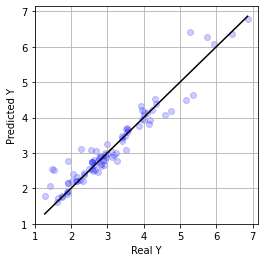

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, xgb_reg.predict(X_test), alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'XGBoost'] = R_square
rmse_sum.loc['Hold-out Validation', 'XGBoost'] = RMSE

### **XGBoost(GridSearchCV)**

In [ ]:
cv_params = {'metric':['rmse'],
             'objective':['reg:squarederror'],
             'n_estimators':[5000],
             'random_state':[0],
             'booster': ['gbtree'],
             'learning_rate':[0.01],
             'min_child_weight':[1,5],
             'max_depth':[1,5],
             'colsample_bytree':[0.5,1.0],
             'subsample':[0.5,1.0]
            }

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_reg = xgb.XGBRegressor()
grid_xgb_reg = GridSearchCV(xgb_reg, cv_params, cv = 2,
                        n_jobs = 5,
                        verbose=True)
grid_xgb_reg.fit(X_train,
             y_train, early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        verbose=1)

print(grid_xgb_reg.best_params_)
print(grid_xgb_reg.best_score_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[0]	validation_0-rmse:2.83236
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2.8064
[2]	validation_0-rmse:2.78132
[3]	validation_0-rmse:2.75512
[4]	validation_0-rmse:2.73048
[5]	validation_0-rmse:2.70768
[6]	validation_0-rmse:2.68427
[7]	validation_0-rmse:2.65913
[8]	validation_0-rmse:2.63511
[9]	validation_0-rmse:2.61157
[10]	validation_0-rmse:2.58688
[11]	validation_0-rmse:2.56436
[12]	validation_0-rmse:2.54227
[13]	validation_0-rmse:2.5189
[14]	validation_0-rmse:2.4966
[15]	validation_0-rmse:2.47359
[16]	validation_0-rmse:2.4509
[17]	validation_0-rmse:2.42898
[18]	validation_0-rmse:2.40677
[19]	validation_0-rmse:2.3862
[20]	validation_0-rmse:2.36421
[21]	validation_0-rmse:2.34499
[22]	validation_0-rmse:2.32376
[23]	validation_0-rmse:2.30308
[24]	validation_0-rmse:2.28281
[25]	validation_0-rmse:2.26283
[26]	validation_0-rmse:2.24368
[27]	validation_0-rmse:2.22421
[28]	validation_0-rms

In [ ]:
pred_2 = grid_xgb_reg.best_estimator_.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(y_test, pred_2)
RMSE = mean_squared_error(y_test, pred_2, squared=False)
MSE = mean_squared_error(y_test, pred_2, squared=True)
MAE = mean_absolute_error(y_test, pred_2)

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

R_square: 0.9273194668403563
RMSE: 0.30914496504997957
MSE:　0.09557060941575309
MAE:　0.21063107782186463


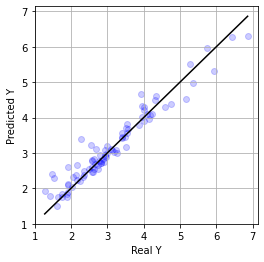

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_test, pred_2, alpha=0.2, c="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'XGBoost(GridSearchCV)'] = R_square
rmse_sum.loc['Hold-out Validation', 'XGBoost(GridSearchCV)'] = RMSE

## ***Gaussian Process Model***

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X = np.atleast_2d(fp_Cbg.values)
y = np.atleast_2d(df_Cbg.iloc[:, -3].values).T

#train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# データのscaling
scaler_y_train = StandardScaler().fit(y_train)
scaler_y_test = StandardScaler().fit(y_test)

# GPモデルの構築
kernel = ConstantKernel() * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)
gpr.fit(X_train, scaler_y_train.transform(y_train))

# kernel関数のパラメータの確認
print(gpr.kernel_)
print(gpr.score(X_test, scaler_y_test.transform(y_test)))
print(mean_squared_error(scaler_y_test.transform(y_test), gpr.predict(X_test), squared=False))

# Other Evaluations
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
R_square = r2_score(scaler_y_test.transform(y_test), gpr.predict(X_test))
RMSE = mean_squared_error(scaler_y_test.transform(y_test), gpr.predict(X_test), squared=False)
MSE = mean_squared_error(scaler_y_test.transform(y_test), gpr.predict(X_test), squared=True)
MAE = mean_absolute_error(scaler_y_test.transform(y_test), gpr.predict(X_test))

print(f'R_square: {R_square}\nRMSE: {RMSE}\nMSE:　{MSE}\nMAE:　{MAE}')

5.42**2 * RBF(length_scale=26.4) + WhiteKernel(noise_level=0.0186)
0.8776264536237515
0.349819305322403
R_square: 0.8776264536237515
RMSE: 0.349819305322403
MSE:　0.12237354637624862
MAE:　0.25519498498074256


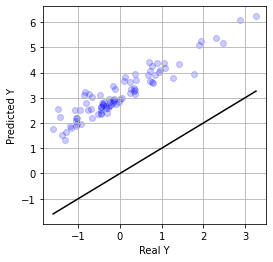

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(scaler_y_test.transform(y_test), pred, alpha=0.2, c="blue")
plt.plot([scaler_y_test.transform(y_test).min(), scaler_y_test.transform(y_test).max()], [scaler_y_test.transform(y_test).min(), scaler_y_test.transform(y_test).max()], c="black")
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [ ]:
r2_sum.loc['Hold-out Validation', 'GP'] = R_square
rmse_sum.loc['Hold-out Validation', 'GP'] = RMSE

# **Cross Validation**

---



## **KFold**

### ***Linear Regression Model***

***Linear Regression(Ordinary)***

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = LinearRegression()
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = -5.388454813308191e+22	rmse = 266357125655.31305
R2 = -8.646039022484256e+22	rmse = 329232328306.3511
R2 = -3.032083052450649e+23	rmse = 701828477107.7297
R2 = -7.419709896060264e+23	rmse = 1046606064016.7006
R2 = -1.3566496315132218e+22	rmse = 132922969361.99362
Average RMSE is 495389392889.61755
Average R square is -2.3981814590482963e+23


In [ ]:
r2_sum.loc['k-fold', 'Linear Regression(Ordinary)'] = avg_rsquare
rmse_sum.loc['k-fold', 'Linear Regression(Ordinary)'] = avg_rmse

***Linear Regression(Lasso)***

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = Lasso(alpha=0.1)
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.675571461826209	rmse = 0.6535694171931916
R2 = 0.7219180669763516	rmse = 0.5904461083333158
R2 = 0.6058717633401551	rmse = 0.8001643802995039
R2 = 0.633599248509271	rmse = 0.7354750797564418
R2 = 0.6998350353375955	rmse = 0.6252391784385418
Average RMSE is 0.6809788328041989
Average R square is 0.6673591151979164


In [ ]:
r2_sum.loc['k-fold', 'Linear Regression(Lasso)'] = avg_rsquare
rmse_sum.loc['k-fold', 'Linear Regression(Lasso)'] = avg_rmse

***Linear Regression(Ridge)***

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = Ridge(alpha=0.1)
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.8431865415743263	rmse = 0.45438487166948494
R2 = 0.9230958792755763	rmse = 0.31050506095244756
R2 = 0.8633005536228714	rmse = 0.4712418121159216
R2 = 0.7030762713280714	rmse = 0.6620826953088036
R2 = 0.824037580185781	rmse = 0.4787140198897652
Average RMSE is 0.47538569198728453
Average R square is 0.8313393651973253


In [ ]:
r2_sum.loc['k-fold', 'Linear Regression(Ridge)'] = avg_rsquare
rmse_sum.loc['k-fold', 'Linear Regression(Ridge)'] = avg_rmse

***Linear Regression(ElasticNet)***

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = ElasticNet(alpha=0.1)
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.697399093306549	rmse = 0.631200464040717
R2 = 0.738631278940239	rmse = 0.5724277563514059
R2 = 0.6646048846135728	rmse = 0.7381401116418682
R2 = 0.6252823203478589	rmse = 0.7437755131039655
R2 = 0.7510276435928991	rmse = 0.5694318418804601
Average RMSE is 0.6509951374036833
Average R square is 0.6953890441602237


In [ ]:
r2_sum.loc['k-fold', 'Linear Regression(ElasticNet)'] = avg_rsquare
rmse_sum.loc['k-fold', 'Linear Regression(ElasticNet)'] = avg_rmse

### ***Random Forest Model***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = RandomForestRegressor()
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.9403867300436632	rmse = 0.2801584134866714
R2 = 0.9337209214442541	rmse = 0.28825849088999167
R2 = 0.8947005844265147	rmse = 0.4135932286785799
R2 = 0.6574578521081533	rmse = 0.7111263847624159
R2 = 0.9188000744676083	rmse = 0.32519510464873214
Average RMSE is 0.4036663244932782
Average R square is 0.8690132324980387


In [ ]:
r2_sum.loc['k-fold', 'RF'] = avg_rsquare
rmse_sum.loc['k-fold', 'RF'] = avg_rmse

### ***SVR Model***

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = SVR()
rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.7217647921007897	rmse = 0.6052547959085423
R2 = 0.7836865740516328	rmse = 0.520757598409568
R2 = 0.7246998056002277	rmse = 0.6687498514162338
R2 = 0.6556456377553987	rmse = 0.7130050053393222
R2 = 0.7935140453901957	rmse = 0.5185748396402831
Average RMSE is 0.6052684181427899
Average R square is 0.7358621709796489


In [ ]:
r2_sum.loc['k-fold', 'SVR'] = avg_rsquare
rmse_sum.loc['k-fold', 'SVR'] = avg_rmse 

***SVR Model(GridSearchCV)***

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)
model = SVR()

parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 10]}
grid_svr = GridSearchCV(model, parameters)

rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  grid_svr.fit(X_train, y_train)
  y_pred = grid_svr.predict(X_test)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.8881723031126748	rmse = 0.3837133305970217
R2 = 0.9379651284562318	rmse = 0.2788764370913869
R2 = 0.8771866929492435	rmse = 0.44666626436879175
R2 = 0.7419729891086227	rmse = 0.6171949583846845
R2 = 0.8630928372439481	rmse = 0.4222593442767955
Average RMSE is 0.42974206694373607
Average R square is 0.8616779901741441


In [ ]:
r2_sum.loc['k-fold', 'SVR(GridSearchCV)'] = avg_rsquare
rmse_sum.loc['k-fold', 'SVR(GridSearchCV)'] = avg_rmse 

### ***XGBoost Model***

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

model = xgb.XGBRegressor()
params = {'metric':'rmse',
          'objective':'reg:squarederror',
          'n_estimators':5000,
          'booster': 'gbtree',
          'learning_rate':0.01,
          'min_child_weight':1,
          'max_depth':5,
          'random_state':0,
          'colsample_bytree':1,
          'subsample':1,
         }
model.set_params(**params)

rmse_list = []
rsquare_list = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train,y_train, early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        verbose=1)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')

avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

Streaming output truncated to the last 5000 lines.
[1938]	validation_0-rmse:0.587034
[1939]	validation_0-rmse:0.587031
[1940]	validation_0-rmse:0.587032
[1941]	validation_0-rmse:0.587004
[1942]	validation_0-rmse:0.587007
[1943]	validation_0-rmse:0.586996
[1944]	validation_0-rmse:0.586985
[1945]	validation_0-rmse:0.586985
[1946]	validation_0-rmse:0.586959
[1947]	validation_0-rmse:0.586957
[1948]	validation_0-rmse:0.586954
[1949]	validation_0-rmse:0.586941
[1950]	validation_0-rmse:0.58693
[1951]	validation_0-rmse:0.586937
[1952]	validation_0-rmse:0.586933
[1953]	validation_0-rmse:0.586913
[1954]	validation_0-rmse:0.586911
[1955]	validation_0-rmse:0.58688
[1956]	validation_0-rmse:0.586878
[1957]	validation_0-rmse:0.586846
[1958]	validation_0-rmse:0.586846
[1959]	validation_0-rmse:0.58685
[1960]	validation_0-rmse:0.586839
[1961]	validation_0-rmse:0.586838
[1962]	validation_0-rmse:0.586807
[1963]	validation_0-rmse:0.586805
[1964]	validation_0-rmse:0.586809
[1965]	validation_0-rmse:0.586811


In [ ]:
r2_sum.loc['k-fold', 'XGBoost'] = avg_rsquare
rmse_sum.loc['k-fold', 'XGBoost'] = avg_rmse

***XGBoost Model(GridSearchCV)***

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
xgb_reg = xgb.XGBRegressor()
rmse_list = []
rsquare_list = []

cv_params = {'metric':['rmse'],
             'objective':['reg:squarederror'],
             'n_estimators':[5000],
             'random_state':[0],
             'booster': ['gbtree'],
             'learning_rate':[0.01],
             'min_child_weight':[1,5],
             'max_depth':[1,5],
             'colsample_bytree':[0.5,1.0],
             'subsample':[0.5,1.0]
            }

model = GridSearchCV(xgb_reg, cv_params, cv = 2,
                        n_jobs = 5,
                        verbose=True)

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model.fit(X_train,y_train, early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        verbose=1)
  y_pred = model.best_estimator_.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rsquare = r2_score(y_test, y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')

avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

Streaming output truncated to the last 5000 lines.
[783]	validation_0-rmse:0.395785
[784]	validation_0-rmse:0.395675
[785]	validation_0-rmse:0.395446
[786]	validation_0-rmse:0.39525
[787]	validation_0-rmse:0.395241
[788]	validation_0-rmse:0.395009
[789]	validation_0-rmse:0.39484
[790]	validation_0-rmse:0.394892
[791]	validation_0-rmse:0.394848
[792]	validation_0-rmse:0.394753
[793]	validation_0-rmse:0.394673
[794]	validation_0-rmse:0.394661
[795]	validation_0-rmse:0.394543
[796]	validation_0-rmse:0.394542
[797]	validation_0-rmse:0.394558
[798]	validation_0-rmse:0.394305
[799]	validation_0-rmse:0.394288
[800]	validation_0-rmse:0.394295
[801]	validation_0-rmse:0.394266
[802]	validation_0-rmse:0.394186
[803]	validation_0-rmse:0.394228
[804]	validation_0-rmse:0.394164
[805]	validation_0-rmse:0.394037
[806]	validation_0-rmse:0.393937
[807]	validation_0-rmse:0.393766
[808]	validation_0-rmse:0.393726
[809]	validation_0-rmse:0.393607
[810]	validation_0-rmse:0.393638
[811]	validation_0-rmse:0.3

In [ ]:
r2_sum.loc['k-fold', 'XGBoost(GridSearchCV)'] = avg_rsquare
rmse_sum.loc['k-fold', 'XGBoost(GridSearchCV)'] = avg_rmse 

### ***Gaussian Process Model***

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# GPモデルの構築
kernel = ConstantKernel() * RBF() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, alpha=0)

rmse_list = []
rsquare_list = []

X = np.atleast_2d(fp_Cbg.values)
y = np.atleast_2d(df_Cbg.iloc[:, -3].values).T



for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # データのscaling
  scaler_y_train = StandardScaler().fit(y_train)
  scaler_y_test = StandardScaler().fit(y_test)
  
  model.fit(X_train, scaler_y_train.transform(y_train))
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(scaler_y_test.transform(y_test), y_pred))
  rsquare = r2_score(scaler_y_test.transform(y_test), y_pred)
  rmse_list.append(rmse)
  rsquare_list.append(rsquare)
  print(f'R2 = {rsquare}\trmse = {rmse}')
avg_rmse = np.mean(rmse_list)
avg_rsquare = np.mean(rsquare_list)
print(f'Average RMSE is {avg_rmse}\nAverage R square is {avg_rsquare}')

R2 = 0.8792905822535652	rmse = 0.34743260892788236
R2 = 0.9315993319165924	rmse = 0.2615352138496988
R2 = 0.877761671261281	rmse = 0.3496259840725786
R2 = 0.7269943949251251	rmse = 0.5224993828464057
R2 = 0.7720026496701804	rmse = 0.477490680882695
Average RMSE is 0.39171677411585215
Average R square is 0.8375297260053488


In [ ]:
r2_sum.loc['k-fold', 'GP'] = avg_rsquare
rmse_sum.loc['k-fold', 'GP'] = avg_rmse 

## **Leave-One-Out**

### **Linear Regression Model**

***Linear Regression(Ordinary)***

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
model = LinearRegression()

rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List type can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [00:09, 31.53it/s]

Average RMSE is 151945321895.58026	Average R square is -1.3421621950235162e+23


In [ ]:
r2_sum.loc['Leave-One-Out', 'Linear Regression(Ordinary)'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'Linear Regression(Ordinary)'] = avg_rmse

***Linear Regression(Lasso)***

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
model = Lasso(alpha=0.1)

rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List type can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [00:01, 171.87it/s]

Average RMSE is 0.48771910633709403	Average R square is 0.6606171129587808


In [ ]:
r2_sum.loc['Leave-One-Out', 'Linear Regression(Lasso)'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'Linear Regression(Lasso)'] = avg_rmse

***Linear Regression(Ridge)***

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
model = Ridge(alpha=0.1)

rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List type can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [00:02, 114.93it/s]

Average RMSE is 0.3059117259946474	Average R square is 0.8505722509515415


In [ ]:
r2_sum.loc['Leave-One-Out', 'Linear Regression(Ridge)'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'Linear Regression(Ridge)'] = avg_rmse

***Linear Regression(ElasticNet)***

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
model = ElasticNet(alpha=0.1)

rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List type can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [00:02, 131.92it/s]

Average RMSE is 0.4537058983040027	Average R square is 0.6920214263637683


In [ ]:
r2_sum.loc['Leave-One-Out', 'Linear Regression(ElasticNet)'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'Linear Regression(ElasticNet)'] = avg_rmse

### ***Random Forest Model***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = RandomForestRegressor()
rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [02:58,  1.59it/s]

Average RMSE is 0.24167035211267612	Average R square is 0.8977016428854921


In [ ]:
r2_sum.loc['Leave-One-Out', 'RF'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'RF'] = avg_rmse

### ***SVR Model***

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = SVR()
rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [00:04, 58.72it/s]

Average RMSE is 0.35106498404462555	Average R square is 0.7550081283502497


In [ ]:
r2_sum.loc['Leave-One-Out', 'SVR'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'SVR'] = avg_rmse

***SVR Model(GridSearchCV)***

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
model = SVR()
rmse_list = []
y_test_group = []
y_pred_group = []

parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'C':[1, 10]}
grid_svr = GridSearchCV(model, parameters)

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  grid_svr.fit(X_train, y_train)
  y_pred = grid_svr.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [20:00,  4.23s/it]

Average RMSE is 0.26628015025284235	Average R square is 0.8838355786516036


In [ ]:
r2_sum.loc['Leave-One-Out', 'SVR(GridSearchCV)'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'SVR(GridSearchCV)'] = avg_rmse

### ***XGBoost Model***

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
rmse_list = []
y_test_group = []
y_pred_group = []

model = xgb.XGBRegressor()
params = {'metric':'rmse',
          'objective':'reg:squarederror',
          'n_estimators':5000,
          'booster': 'gbtree',
          'learning_rate':0.01,
          'min_child_weight':1,
          'max_depth':5,
          'random_state':0,
          'colsample_bytree':1,
          'subsample':1,
         }
model.set_params(**params)

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values

for train_index, test_index in tqdm(loo.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_test_group.append(y_test)
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred)
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_list.append(rmse)
avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

284it [1:48:50, 23.00s/it]

Average RMSE is 0.19929447341636872	Average R square is 0.9263870390185227


In [ ]:
r2_sum.loc['Leave-One-Out', 'XGBoost'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'XGBoost'] = avg_rmse

***XGBoost Model(GridSearchCV)***

In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import LeaveOneOut
# loo = LeaveOneOut()
# xgb_reg = xgb.XGBRegressor()
# rmse_list = []
# y_test_group = []
# y_pred_group = []

# cv_params = {'metric':['rmse'],
#              'objective':['reg:squarederror'],
#              'n_estimators':[5000],
#              'random_state':[0],
#              'booster': ['gbtree'],
#              'learning_rate':[0.01],
#              'min_child_weight':[1,5],
#              'max_depth':[1,5],
#              'colsample_bytree':[0.5,1.0],
#              'subsample':[0.5,1.0]
#             }

# model = GridSearchCV(xgb_reg, cv_params, cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

# X = fp_Cbg.values
# y = df_Cbg.iloc[:, -3].values

# for train_index, test_index in tqdm(loo.split(X)):
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]
#   y_test_group.append(y_test)
  
#   model.fit(X_train, y_train)
#   y_pred = model.predict(X_test)
#   y_pred_group.append(y_pred)
  
#   rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#   rmse_list.append(rmse)
# avg_rmse = np.mean(rmse_list)
# avg_rsquare = r2_score(y_test_group, y_pred_group) #List can be used in R square

# print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

In [ ]:
# r2_sum.loc['Leave-One-Out', 'XGBoost (GridSearchCV)'] = avg_rsquare
# rmse_sum.loc['Leave-One-Out', 'XGBoost (GridSearchCV)'] = avg_rmse

### ***Gaussian Process Model***

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
kernel = ConstantKernel() * RBF() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, alpha=0)
rmse_list = []
y_test_group = []
y_pred_group = []

X = fp_Cbg.values
y = df_Cbg.iloc[:, -3].values.reshape(-1, 1)

for train_index, test_index in loo.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  scaler_y_train = StandardScaler().fit(y_train)

  y_test_group.append(scaler_y_train.transform(y_test)[0])

  model.fit(X_train, scaler_y_train.transform(y_train))
  y_pred = model.predict(X_test)
  y_pred_group.append(y_pred[0])

  rmse = np.sqrt(mean_squared_error(scaler_y_train.transform(y_test), y_pred))
  rmse_list.append(rmse)

avg_rmse = np.mean(rmse_list)
avg_rsquare = r2_score(y_pred_group, y_test_group)
print(f'Average RMSE is {avg_rmse}\tAverage R square is {avg_rsquare}')

Average RMSE is 0.2206752136344898	Average R square is 0.8545966340882302


In [ ]:
r2_sum.loc['Leave-One-Out', 'GP'] = avg_rsquare
rmse_sum.loc['Leave-One-Out', 'GP'] = avg_rmse

# **Evaluation Summary**

---



In [ ]:
r2_sum

,Linear Regression(Ordinary),Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,SVR,SVR(GridSearchCV),XGBoost,XGBoost(GridSearchCV),GP
Hold-out Validation,-7.464662e+23,0.676140,0.854503,0.696865,0.908674,0.701032,0.878300,0.913870,0.927319,0.877626
k-fold,-2.398181e+23,0.667359,0.831339,0.695389,0.869013,0.735862,0.861678,0.903418,0.914207,0.837530
Leave-One-Out,-1.342162e+23,0.660617,0.850572,0.692021,0.897702,0.755008,0.883836,0.926387,NaN,0.854597


In [ ]:
rmse_sum

,Linear Regression(Ordinary),Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,SVR,SVR(GridSearchCV),XGBoost,XGBoost(GridSearchCV),GP
Hold-out Validation,9.907366e+11,0.652577,0.437401,0.631351,0.346538,0.626997,0.400036,0.336535,0.309145,0.349819
k-fold,4.953894e+11,0.680979,0.475386,0.650995,0.403666,0.605268,0.429742,0.352370,0.334205,0.391717
Leave-One-Out,1.519453e+11,0.487719,0.305912,0.453706,0.241670,0.351065,0.266280,0.199294,NaN,0.220675
